# Redes Neuronales - TP2
## Ej 8

Encontrar un perceptrón multicapa que resuelva una XOR de 2 entradas mediante
simulated annealing. Graficar el error a lo largo del proceso de aprendizaje.

Todo este código es bastante reciclado del ej3, que pedia lo mismo pero con gradiente descendiente.

In [105]:
import numpy as np
import matplotlib.pyplot as plt

In [106]:
class perceptron_multicapa:
    def __init__(self, capas, dim_entrada):
        self.capas = capas
        self.dim_entrada = dim_entrada
        self.lista_matrices = []
        self.lr = None
        entrada_anterior = dim_entrada
        for num_perceptrones in capas:
            matriz_pesos = np.random.uniform(-2, 2, size=(num_perceptrones, entrada_anterior + 1)) # inicialización más amplia
            self.lista_matrices.append(matriz_pesos)
            entrada_anterior = num_perceptrones

    def funcion_activacion(self, x):
        """Función de activación sigmoide"""
        return 1 / (1 + np.exp(-x))


    def predecir(self, X):
        salidas = []
        for x in X:
            a = x
            for W in self.lista_matrices:
                a = np.concatenate(([1], a))
                a = self.funcion_activacion(np.dot(W, a))
            salidas.append(a.reshape(-1))  # garantiza que sea vector 1D
        return np.array(salidas).reshape(len(X), -1)

    def predecir_hard(self, X):
        salidas = self.predecir(X)
        # Si la salida es entre 0 y 1 (sigmoide), umbral en 0.5
        return (salidas >= 0.5).astype(int)

    def calcular_error(self, X, Y):
        """Calcula el error cuadrático medio para un conjunto de datos"""
        pred = self.predecir(X)
        return np.mean((pred - Y) ** 2)

    def entrenar(self, X, Y, T0=1.0, epochs=20000, sigma=0.1, decay_rate=0.995, decay_type='exponential'):
        """
        Entrena el perceptrón usando Simulated Annealing

        Parámetros:
        - T0: temperatura inicial
        - epochs: número de épocas
        - sigma: desviación estándar para la perturbación gaussiana
        - decay_rate: tasa de decaimiento de la temperatura (entre 0 y 1)
        - decay_type: tipo de decaimiento ('exponential' o 'linear')

        Nota: se guardan `self.error_por_epoch` y `self.T_history` en los mismos puntos
        para poder graficar ECM y temperatura en conjunto.
        """
        n_samples = X.shape[0]
        self.error_por_epoch = []
        self.T_history = []
        T = T0  # temperatura inicial

        # Guardamos la mejor solución encontrada
        mejor_matrices = [W.copy() for W in self.lista_matrices]
        mejor_error = self.calcular_error(X, Y)

        for epoch in range(epochs):
            # Copiamos los pesos actuales
            matrices_actuales = [W.copy() for W in self.lista_matrices]

            # Perturbamos los pesos con ruido gaussiano
            for l in range(len(self.lista_matrices)):
                perturbacion = np.random.normal(0, sigma, self.lista_matrices[l].shape)
                self.lista_matrices[l] = matrices_actuales[l] + perturbacion

            # Calculamos el cambio en el error (comparado con la mejor solución hasta ahora)
            error_actual = self.calcular_error(X, Y)
            delta_error = error_actual - mejor_error

            # Evitar división por cero en la probabilidad de Metropolis
            T_safe = max(T, 1e-12)

            # Criterio de aceptación de Metropolis
            if delta_error < 0 or np.random.random() < np.exp(-delta_error / T_safe):
                # Aceptamos el cambio
                mejor_error = error_actual
                mejor_matrices = [W.copy() for W in self.lista_matrices]
            else:
                # Rechazamos el cambio y restauramos los pesos anteriores
                self.lista_matrices = matrices_actuales

            # Actualizamos la temperatura según el tipo de decaimiento
            if decay_type == 'exponential':
                T = T0 * (decay_rate ** epoch)
            else:  # linear decay
                T = T0 * (1 - epoch/epochs)

            # Guardamos el error y la temperatura para visualización en los mismos puntos
            if epoch % 100 == 0 or epoch == epochs-1:
                self.error_por_epoch.append(mejor_error)
                self.T_history.append(T)

        # Restauramos los mejores pesos encontrados
        self.lista_matrices = mejor_matrices

Aunque solo se pide la XOR de 2 entradas, podemos hacerlo para la de 4 tambien, que es lo peor que puede pasar? 

In [107]:
# datos para la XOR de 2 entradas y 1 salida (corregido)
A = np.array([0, 0, 1, 1])
B = np.array([0, 1, 0, 1])
Y12 = np.array([0, 1, 1, 0])
datos_XOR2 = np.column_stack((A, B, Y12))


In [108]:
# los construí en 1 y -1 pero desp lo paso a 0 y 1, no lo hago acá porque cada vez que hago un control replace cambio todos los -1 del resto del código

A = np.array([-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1])
B = np.array([-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1])
C = np.array([-1,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,1,1,1,1])
D = np.array([-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1])
Y14 = np.array([-1,1,1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1])
datos_XOR4 = np.column_stack((A, B, C, D, Y14))


In [109]:
# ahora toca entrenar el perceptron con estos datos
test2 = perceptron_multicapa(capas=[4,1], dim_entrada=2) # para la XOR de 2 entradas y 1 salida
test4 = perceptron_multicapa(capas=[4, 1], dim_entrada=4) # para la XOR de 4 entradas y 1 salida

# entrenamos ambos modelos con sus respectivos datos y targets 
X2 = datos_XOR2[:, 0:2]
Y2 = datos_XOR2[:, 2].reshape(-1, 1)  # targets 0/1 para sigmoide

# test2.entrenar(X2, Y2, T0=1.0, epochs=20000, sigma=0.1, decay_rate=0.999)

In [110]:
def plot_frontera(model, X, Y, titulo="Frontera de decisión", h=0.01, cmap="bwr"):
    """Dibuja la frontera de decisión para datos 2D usando el modelo dado.
    model: objeto con método `predecir` que recibe una matriz (N,2)
    X, Y: datos originales (Y util para colorear puntos)
    """
    # límites
    x_min, x_max = X[:,0].min() - 0.1, X[:,0].max() + 0.1
    y_min, y_max = X[:,1].min() - 0.1, X[:,1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    pts = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predecir(pts)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(5,4))
    plt.contourf(xx, yy, Z, levels=[0,0.5,1], alpha=0.3, cmap=cmap)
    plt.scatter(X[:,0], X[:,1], c=Y.reshape(-1), cmap=cmap, edgecolors='k')
    plt.title(titulo)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.show()

# Reemplazado: ahora hay una función reutilizable para graficar fronteras.


In [111]:
def graficar_error(modelo, titulo, mostrar_lista_T=False):
    plt.figure(figsize=(8,4))
    epochs_saved = np.arange(len(modelo.error_por_epoch)) * 100
    # Plot ECM (línea, sin markers)
    ax1 = plt.gca()
    ax1.plot(epochs_saved, modelo.error_por_epoch, color='C0', label='ECM')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('ECM', color='C0')
    ax1.tick_params(axis='y', labelcolor='C0')
    ax1.grid(True)

    # Si el modelo tiene historial de temperatura, ploteamos en eje secundario
    if hasattr(modelo, 'T_history') and len(modelo.T_history) == len(modelo.error_por_epoch):
        ax2 = ax1.twinx()
        # Línea de temperatura sin markers
        ax2.plot(epochs_saved, modelo.T_history, linestyle='--', color='C1', label='Temperatura')
        ax2.set_ylabel('Temperatura', color='C1')
        ax2.tick_params(axis='y', labelcolor='C1')

        # Añadimos un recuadro con T inicial y final (sin N_puntos)
        try:
            T0 = modelo.T_history[0]
            T_final = modelo.T_history[-1]
            info_text = f"T0 = {T0:.6g}\nT_final = {T_final:.6g}"
            ax1.text(0.02, 0.95, info_text, transform=ax1.transAxes,
                     fontsize=9, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
        except Exception:
            pass

        # Leyenda combinada
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        # Opción: imprimir la lista completa de temperaturas si se pide
        if mostrar_lista_T:
            print("Historial de temperaturas (muestras guardadas):", modelo.T_history)

    else:
        ax1.legend(loc='upper right')

    plt.title(titulo)
    plt.show()

# Graficar error para XOR 2 entradas
#graficar_error(test2, "Evolución del error (ECM) y Temperatura - XOR 2 entradas")

# Graficar error para XOR 4 entradas
#graficar_error(test4, "Evolución del error (ECM) y Temperatura - XOR 4 entradas")

Entrenando XOR2 con 2 neuronas en la capa oculta...


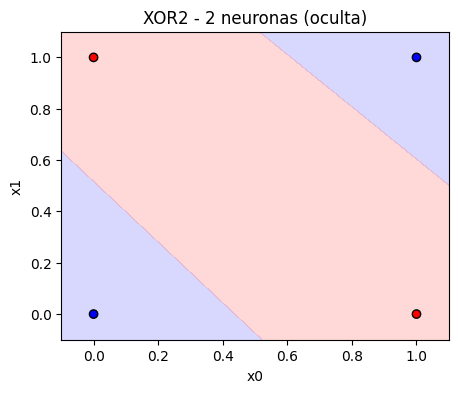

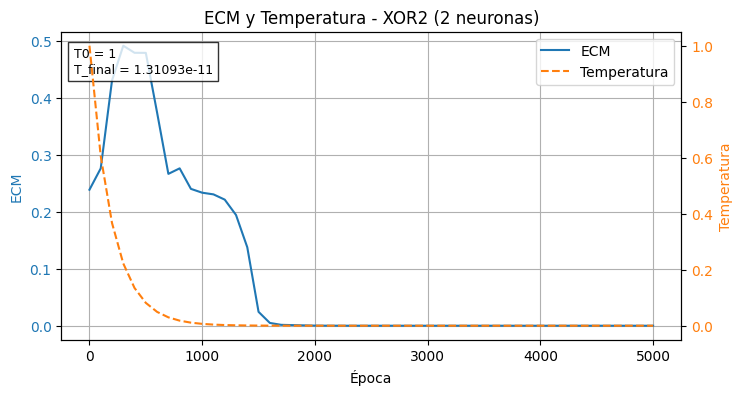

Predicciones soft:
[0 0] -> target 0, pred 0.000, hard 0
[0 1] -> target 1, pred 1.000, hard 1
[1 0] -> target 1, pred 1.000, hard 1
[1 1] -> target 0, pred 0.000, hard 0


Entrenando XOR2 con 4 neuronas en la capa oculta...


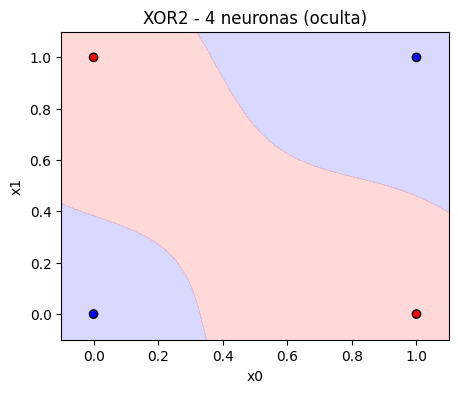

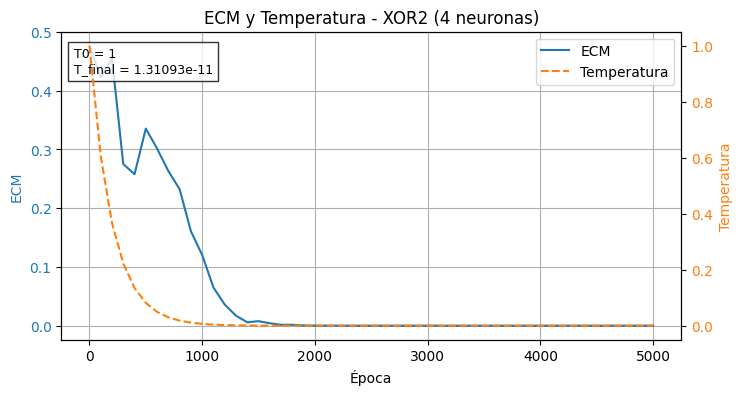

Predicciones soft:
[0 0] -> target 0, pred 0.000, hard 0
[0 1] -> target 1, pred 1.000, hard 1
[1 0] -> target 1, pred 1.000, hard 1
[1 1] -> target 0, pred 0.000, hard 0


Entrenando XOR2 con 10 neuronas en la capa oculta...


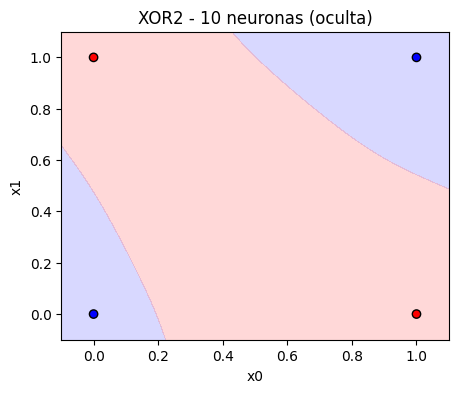

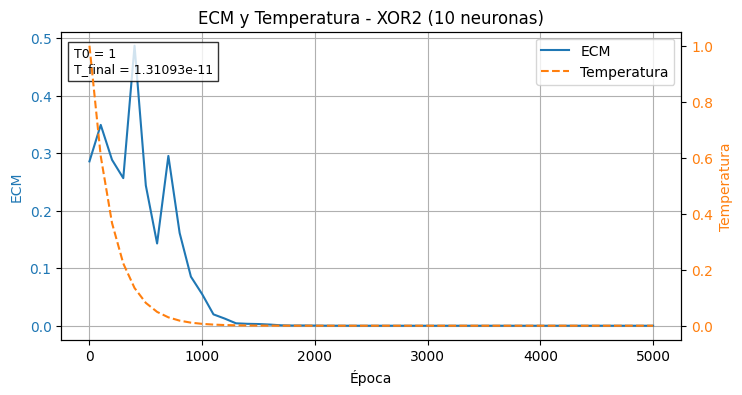

Predicciones soft:
[0 0] -> target 0, pred 0.000, hard 0
[0 1] -> target 1, pred 1.000, hard 1
[1 0] -> target 1, pred 1.000, hard 1
[1 1] -> target 0, pred 0.000, hard 0


Comparando dos decay_rate para hidden=2
Entrenando decay_rate=0.98


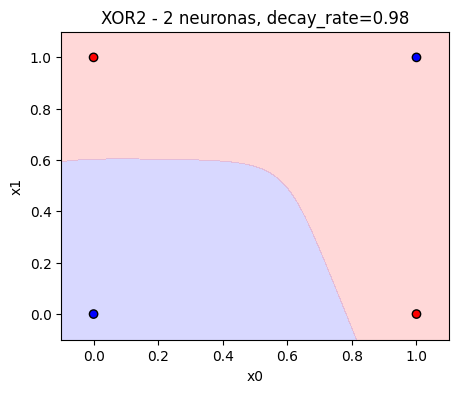

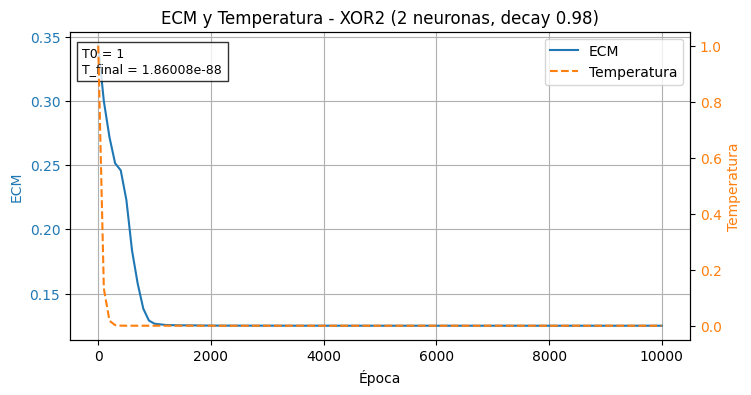


----------------------------------------

Entrenando decay_rate=0.999


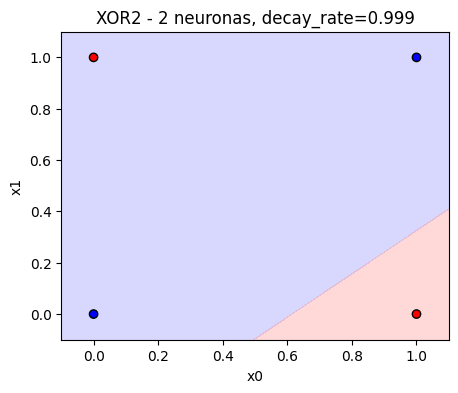

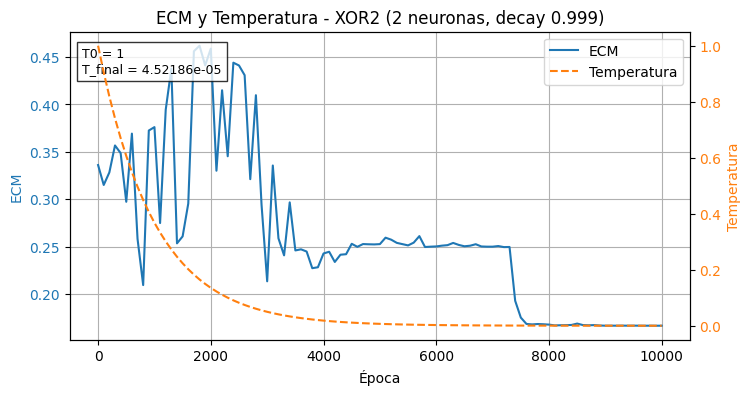


----------------------------------------



In [116]:
# === Experimentos solicitados ===
# XOR de 2 entradas: probar capas ocultas con 2, 4 y 10 neuronas
hidden_sizes = [2, 4, 10]
models_xor2 = {}
for hsize in hidden_sizes:
    print(f"Entrenando XOR2 con {hsize} neuronas en la capa oculta...")
    m = perceptron_multicapa(capas=[hsize, 1], dim_entrada=2)
    # parámetros razonables; puedes ajustar epochs si tarda mucho
    m.entrenar(X2, Y2, T0=1.0, epochs=5000, sigma=0.1, decay_rate=0.995, decay_type='exponential')
    models_xor2[hsize] = m
    # mostrar frontera y error
    plot_frontera(m, X2, Y2, titulo=f"XOR2 - {hsize} neuronas (oculta)")
    graficar_error(m, f"ECM y Temperatura - XOR2 ({hsize} neuronas)")
    # mostrar predicciones
    preds = m.predecir(X2)
    print("Predicciones soft:")
    for x, y, p in zip(X2, Y2, preds):
        print(f"{x} -> target {int(y[0])}, pred {p[0]:.3f}, hard {int(p[0]>=0.5)}")
    print('\n' + '='*50 + '\n')

# Para capa oculta = 2: comparar dos decay_rate distintos
print("Comparando dos decay_rate para hidden=2")
decay_cases = [0.98, 0.999]
models_decay = {}
for d in decay_cases:
    print(f"Entrenando decay_rate={d}")
    m = perceptron_multicapa(capas=[2,1], dim_entrada=2)
    m.entrenar(X2, Y2, T0=1.0, epochs=10000, sigma=0.1, decay_rate=d, decay_type='exponential')
    models_decay[d] = m
    plot_frontera(m, X2, Y2, titulo=f"XOR2 - 2 neuronas, decay_rate={d}")
    graficar_error(m, f"ECM y Temperatura - XOR2 (2 neuronas, decay {d})")
    print('\n' + '-'*40 + '\n')



XOR4: entrenando con 4 neuronas en la capa oculta (dim entrada = 4)


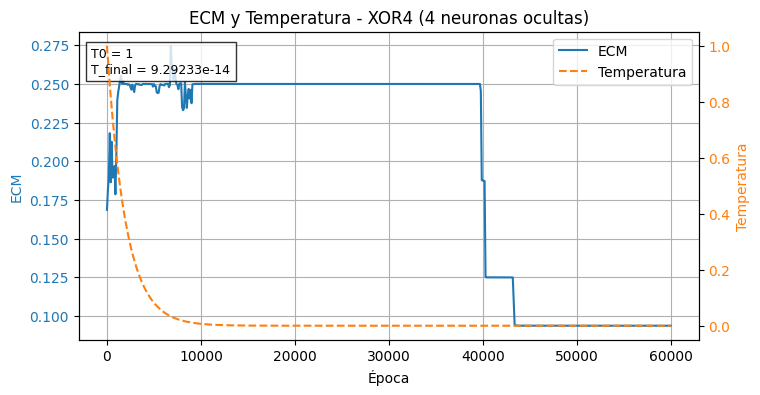

Predicciones (soft) para XOR4:
[-1 -1 -1 -1] -> target 0, pred 0.000, hard 0
[ 1 -1 -1 -1] -> target 1, pred 0.500, hard 0
[-1  1 -1 -1] -> target 1, pred 1.000, hard 1
[ 1  1 -1 -1] -> target 0, pred 0.500, hard 0
[-1 -1  1 -1] -> target 1, pred 0.000, hard 0
[ 1 -1  1 -1] -> target 0, pred 0.000, hard 0
[-1  1  1 -1] -> target 0, pred 0.000, hard 0
[ 1  1  1 -1] -> target 0, pred 0.000, hard 0
[-1 -1 -1  1] -> target 1, pred 1.000, hard 1
[ 1 -1 -1  1] -> target 0, pred 0.000, hard 0
[-1  1 -1  1] -> target 0, pred 0.000, hard 0
[ 1  1 -1  1] -> target 0, pred 0.000, hard 0
[-1 -1  1  1] -> target 0, pred 0.000, hard 0
[ 1 -1  1  1] -> target 0, pred 0.000, hard 0
[-1  1  1  1] -> target 0, pred 0.000, hard 0
[1 1 1 1] -> target 0, pred 0.000, hard 0

Experimentos completados.


In [113]:

# XOR de 4 entradas: comprobar que una oculta de 4 neuronas puede aprenderlo
print("XOR4: entrenando con 4 neuronas en la capa oculta (dim entrada = 4)")
model_xor4_4 = perceptron_multicapa(capas=[4,1], dim_entrada=4)
# usar más épocas porque el espacio es mayor
model_xor4_4.entrenar(X4, Y4, T0=1.0, epochs=60000, sigma=0.1, decay_rate=0.9995, decay_type='exponential')
# No podemos graficar frontera en 4D; mostramos ECM/Temperatura y predicciones
graficar_error(model_xor4_4, "ECM y Temperatura - XOR4 (4 neuronas ocultas)")
print("Predicciones (soft) para XOR4:")
preds4 = model_xor4_4.predecir(X4)
for x, y, p in zip(X4, Y4, preds4):
    print(f"{x} -> target {int(y[0])}, pred {p[0]:.3f}, hard {int(p[0]>=0.5)}")

print('\nExperimentos completados.')

XOR4: entrenando con 4 neuronas en la capa oculta (dim entrada = 4)


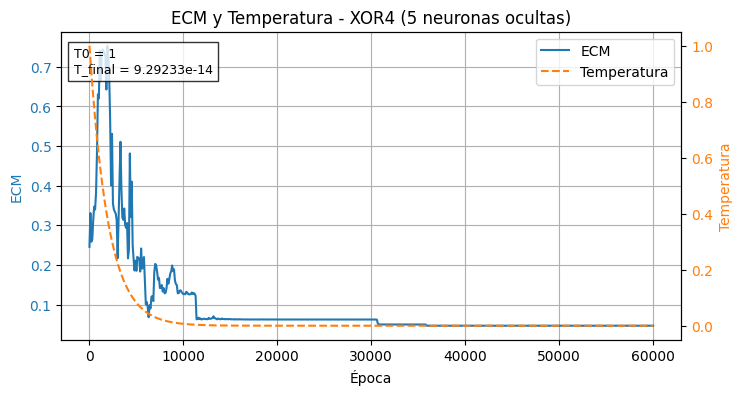

Predicciones (soft) para XOR4:
[-1 -1 -1 -1] -> target 0, pred 0.000, hard 0
[ 1 -1 -1 -1] -> target 1, pred 1.000, hard 1
[-1  1 -1 -1] -> target 1, pred 0.250, hard 0
[ 1  1 -1 -1] -> target 0, pred 0.250, hard 0
[-1 -1  1 -1] -> target 1, pred 1.000, hard 1
[ 1 -1  1 -1] -> target 0, pred 0.000, hard 0
[-1  1  1 -1] -> target 0, pred 0.000, hard 0
[ 1  1  1 -1] -> target 0, pred 0.000, hard 0
[-1 -1 -1  1] -> target 1, pred 1.000, hard 1
[ 1 -1 -1  1] -> target 0, pred 0.250, hard 0
[-1  1 -1  1] -> target 0, pred 0.000, hard 0
[ 1  1 -1  1] -> target 0, pred 0.250, hard 0
[-1 -1  1  1] -> target 0, pred 0.000, hard 0
[ 1 -1  1  1] -> target 0, pred 0.000, hard 0
[-1  1  1  1] -> target 0, pred 0.000, hard 0
[1 1 1 1] -> target 0, pred 0.000, hard 0

Experimentos completados.


In [114]:

# XOR de 4 entradas: comprobar que una oculta de 4 neuronas puede aprenderlo
print("XOR4: entrenando con 4 neuronas en la capa oculta (dim entrada = 4)")
model_xor4_4 = perceptron_multicapa(capas=[5,1], dim_entrada=4)
# usar más épocas porque el espacio es mayor
model_xor4_4.entrenar(X4, Y4, T0=1.0, epochs=60000, sigma=0.1, decay_rate=0.9995, decay_type='exponential')
# No podemos graficar frontera en 4D; mostramos ECM/Temperatura y predicciones
graficar_error(model_xor4_4, "ECM y Temperatura - XOR4 (5 neuronas ocultas)")
print("Predicciones (soft) para XOR4:")
preds4 = model_xor4_4.predecir(X4)
for x, y, p in zip(X4, Y4, preds4):
    print(f"{x} -> target {int(y[0])}, pred {p[0]:.3f}, hard {int(p[0]>=0.5)}")

print('\nExperimentos completados.')

XOR4: entrenando con 4 neuronas en la capa oculta (dim entrada = 4)


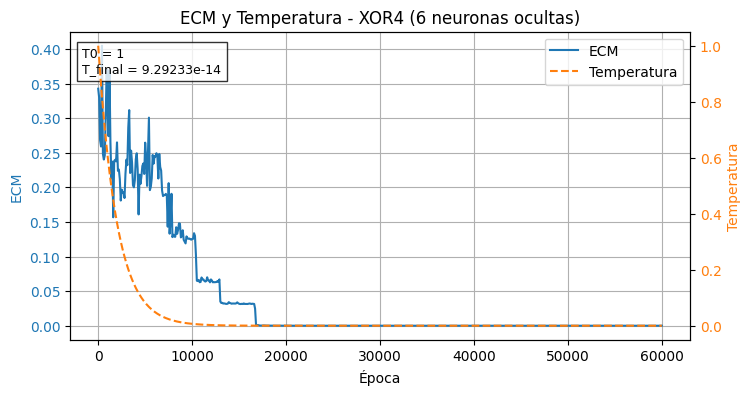

Predicciones (soft) para XOR4:
[-1 -1 -1 -1] -> target 0, pred 0.000, hard 0
[ 1 -1 -1 -1] -> target 1, pred 1.000, hard 1
[-1  1 -1 -1] -> target 1, pred 1.000, hard 1
[ 1  1 -1 -1] -> target 0, pred 0.000, hard 0
[-1 -1  1 -1] -> target 1, pred 1.000, hard 1
[ 1 -1  1 -1] -> target 0, pred 0.000, hard 0
[-1  1  1 -1] -> target 0, pred 0.000, hard 0
[ 1  1  1 -1] -> target 0, pred 0.000, hard 0
[-1 -1 -1  1] -> target 1, pred 1.000, hard 1
[ 1 -1 -1  1] -> target 0, pred 0.000, hard 0
[-1  1 -1  1] -> target 0, pred 0.000, hard 0
[ 1  1 -1  1] -> target 0, pred 0.000, hard 0
[-1 -1  1  1] -> target 0, pred 0.000, hard 0
[ 1 -1  1  1] -> target 0, pred 0.000, hard 0
[-1  1  1  1] -> target 0, pred 0.000, hard 0
[1 1 1 1] -> target 0, pred 0.000, hard 0

Experimentos completados.


In [115]:

# XOR de 4 entradas: comprobar que una oculta de 4 neuronas puede aprenderlo
print("XOR4: entrenando con 4 neuronas en la capa oculta (dim entrada = 4)")
model_xor4_4 = perceptron_multicapa(capas=[6,1], dim_entrada=4)
# usar más épocas porque el espacio es mayor
model_xor4_4.entrenar(X4, Y4, T0=1.0, epochs=60000, sigma=0.1, decay_rate=0.9995, decay_type='exponential')
# No podemos graficar frontera en 4D; mostramos ECM/Temperatura y predicciones
graficar_error(model_xor4_4, "ECM y Temperatura - XOR4 (6 neuronas ocultas)")
print("Predicciones (soft) para XOR4:")
preds4 = model_xor4_4.predecir(X4)
for x, y, p in zip(X4, Y4, preds4):
    print(f"{x} -> target {int(y[0])}, pred {p[0]:.3f}, hard {int(p[0]>=0.5)}")

print('\nExperimentos completados.')